# 1. Introduction: What is an RBF Network?

In [1]:
# Import required libraries

# Avoid KMeans memory leak issue on Windows with Intel MKL
import os
os.environ['OMP_NUM_THREADS'] = '1'
import warnings
warnings.filterwarnings('ignore', message='KMeans is known to have a memory leak')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(42)
print("Libraries loaded successfully!")

Libraries loaded successfully!


# 2. The Gaussian (RBF) Activation Function

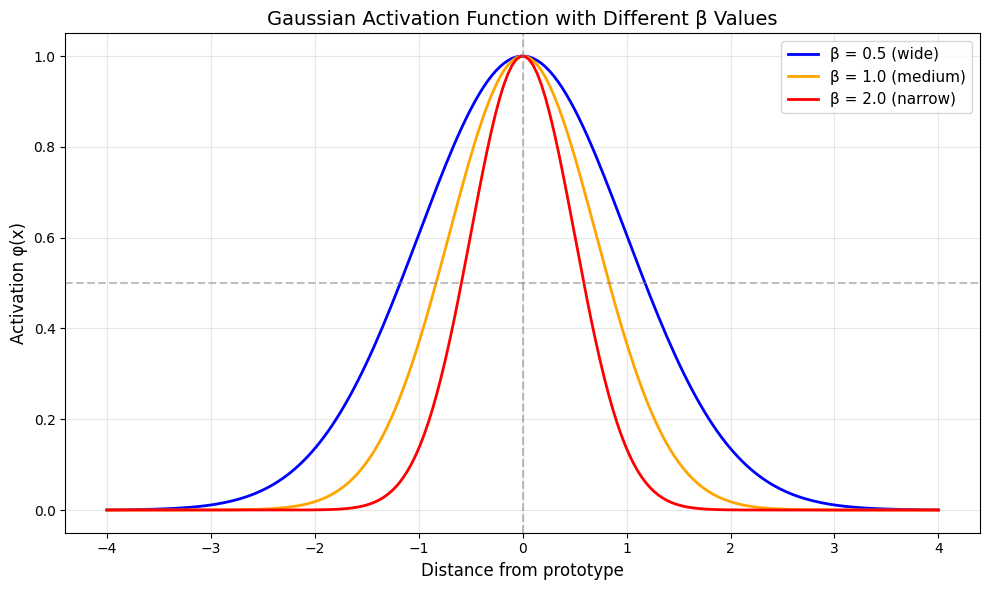


Key observation:
- When input equals prototype (distance = 0), activation = 1.0
- As input moves away from prototype, activation falls towards 0
- β controls how quickly the activation falls off


In [2]:
# Visualise the Gaussian function with different β values
def gaussian(x, centre, beta):
    """
    Compute Gaussian activation.
    
    Parameters:
    x: Input value(s)
    centre: The prototype/centre of the Gaussian
    beta: Width parameter (larger = narrower curve)
    Returns:
    Activation value(s) in range [0, 1]
    """
    distance_squared = (x - centre) ** 2
    ## TODO: use the numpy's "exp" function to return the gaussian activation
    return np.exp(-beta * distance_squared)

# Create x values
## TODO: use the numpy's "linspace" function to create 200 evenly
## spaced values for x over the interval [-4,4].
x = np.linspace(-4, 4, 200)

centre = 0  # Prototype at origin

# Plot Gaussians with different β values
plt.figure(figsize=(10, 6))

for beta, color, label in [(0.5, 'blue', 'β = 0.5 (wide)'), 
                           (1.0, 'orange', 'β = 1.0 (medium)'), 
                           (2.0, 'red', 'β = 2.0 (narrow)')]:
    y = gaussian(x, centre, beta)
    plt.plot(x, y, color=color, linewidth=2, label=label)

plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
plt.xlabel('Distance from prototype', fontsize=12)
plt.ylabel('Activation φ(x)', fontsize=12)
plt.title('Gaussian Activation Function with Different β Values', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig('gaussian_activation.png', dpi=150)
plt.show()

print("\nKey observation:")
print("- When input equals prototype (distance = 0), activation = 1.0")
print("- As input moves away from prototype, activation falls towards 0")
print("- β controls how quickly the activation falls off")

# 3. RBF Network Implementation (From Scratch)

In [3]:
class RBFNetwork:
    """
    Radial Basis Function Network for classification.
    
    Architecture:
    - Input layer: passes input directly to hidden layer
    - Hidden layer: RBF neurons, each storing a prototype
    - Output layer: weighted sum (no activation function)
    
    Training:
    1. Select prototypes using k-means clustering
    2. Compute β from cluster spreads
    3. Learn output weights using pseudoinverse
    """
    
    def __init__(self, n_prototypes=10):
        """
        Initialise RBF network.
        
        Parameters:
        n_prototypes: Number of RBF neurons (prototypes) in hidden layer
        """
        self.n_prototypes = n_prototypes
        self.prototypes = None  # Will store prototype vectors
        self.betas = None  # Will store β for each prototype
        self.weights = None  # Will store output layer weights
    
    def _euclidean_distance(self, x, prototype):
        """
        Compute Euclidean distance between input and prototype.
        
        ||x - p|| = sqrt(Σ(xᵢ - pᵢ)²)
        """
        ## TODO: use numpy's "sqrt" and "sum" (making axis=-1) functions
        ## to compute and return the Euclidean distance
        return np.sqrt(np.sum((x - prototype) ** 2, axis=-1))
    
    def _gaussian_activation(self, distance, beta):
        """
        Compute Gaussian activation: φ = exp(-β * d²)
        
        Parameters:
        distance: Euclidean distance from prototype
        beta: Width parameter
        
        Returns:
        Activation value in [0, 1]
        """
        return np.exp(-beta * distance ** 2)
    
    def _compute_hidden_activations(self, X):
        """
        Compute activations of all RBF neurons for all inputs.
        
        Parameters:
        X: Input data, shape (n_samples, n_features)
        
        Returns:
        Activation matrix, shape (n_samples, n_prototypes)
        """
        ## TODO: given that 'X' is a 2D NumPy array, read its number of
        ## rows (i.e. samples) into a new variable named "n_samples".
        n_samples = X.shape[0]
        
        activations = np.zeros((n_samples, self.n_prototypes))
        
        # For each prototype, compute activation for all samples
        for j, (prototype, beta) in enumerate(zip(self.prototypes, self.betas)):
            distances = self._euclidean_distance(X, prototype)
            activations[:, j] = self._gaussian_activation(distances, beta)
        
        return activations
    
    def fit(self, X, y):
        """
        Train the RBF network.
        
        Stage 1: Select prototypes using k-means clustering
        Stage 2: Compute β values from cluster spreads
        Stage 3: Learn output weights using least squares
        
        Parameters:
        X: Training data, shape (n_samples, n_features)
        y: Target labels (one-hot encoded), shape (n_samples, n_classes)
        """
        print(f"Training RBF Network with {self.n_prototypes} prototypes...")
        
        # ============================================================
        # STAGE 1: Select prototypes using k-means clustering
        # ============================================================
        # K-means finds cluster centres that represent the data distribution
        # These centres become our RBF neuron prototypes
        
        kmeans = KMeans(n_clusters=self.n_prototypes, random_state=42, n_init=10)
        kmeans.fit(X)
        self.prototypes = kmeans.cluster_centers_
        
        print(f"  Stage 1: Selected {self.n_prototypes} prototypes via k-means")
        
        # ============================================================
        # STAGE 2: Compute β for each prototype
        # ============================================================
        # β = 1 / (2σ²) where σ is the spread of the cluster
        # We use the average distance from cluster centre to its members
        
        self.betas = np.zeros(self.n_prototypes)
        
        for j in range(self.n_prototypes):
            # Find all points belonging to this cluster
            cluster_points = X[kmeans.labels_ == j]
            
            if len(cluster_points) > 1:
                # Compute average distance to cluster centre
                distances = self._euclidean_distance(cluster_points, self.prototypes[j])
                ## TODO: use NumPy's "mean" function to calculate "sigma" as the mean
                ## of the Euclidean "distances"
                sigma = np.mean(distances)
                
                # Avoid division by zero
                if sigma > 0:
                    self.betas[j] = 1 / (2 * sigma ** 2)
                else:
                    self.betas[j] = 1.0  # Default if all points identical
            else:
                self.betas[j] = 1.0  # Default for single-point clusters
        
        print(f"  Stage 2: Computed β values (mean={self.betas.mean():.3f})")
        
        # ============================================================
        # STAGE 3: Learn output weights using least squares
        # ============================================================
        # We need to find weights W such that: H @ W ≈ Y
        # Where H is the hidden layer activation matrix
        # Solution: W = (H^T H)^(-1) H^T Y (pseudoinverse)
        
        # Compute hidden layer activations for all training samples
        H = self._compute_hidden_activations(X)
        
        # Add bias column (column of 1s) to handle offset
        H_bias = np.column_stack([H, np.ones(H.shape[0])])
        
        # Compute weights using pseudoinverse (more stable than direct inverse)
        # W = pinv(H) @ Y
        self.weights = np.linalg.pinv(H_bias) @ y
        
        print(f"  Stage 3: Learned output weights, shape={self.weights.shape}")
        print("Training complete!")
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities for input samples.
        
        Parameters:
        X: Input data, shape (n_samples, n_features)
        
        Returns:
        Class scores, shape (n_samples, n_classes)
        """
        # Compute hidden layer activations
        H = self._compute_hidden_activations(X)
        
        # Add bias column
        H_bias = np.column_stack([H, np.ones(H.shape[0])])
        
        # Compute output: weighted sum (no activation function)
        output = H_bias @ self.weights
        
        return output
    
    def predict(self, X):
        """
        Predict class labels for input samples.
        
        Parameters:
        X: Input data, shape (n_samples, n_features)
        
        Returns:
        Predicted class indices, shape (n_samples,)
        """
        scores = self.predict_proba(X)
        ## TODO: use NumPy's "argmax" function to identify and return the
        ## indices of the highest values for each row of "scores".
        return np.argmax(scores, axis=1)

print("RBFNetwork class defined successfully!")
print("\nKey components:")
print(" - _euclidean_distance(): Computes ||x - p||")
print(" - _gaussian_activation(): Computes exp(-β * d²)")
print(" - fit(): Three-stage training (prototypes, betas, weights)")
print(" - predict(): Classification using trained network")

RBFNetwork class defined successfully!

Key components:
 - _euclidean_distance(): Computes ||x - p||
 - _gaussian_activation(): Computes exp(-β * d²)
 - fit(): Three-stage training (prototypes, betas, weights)
 - predict(): Classification using trained network


# 4. Apply Iris Dataset

In [4]:
# Load and prepare the Iris dataset

# Load data
iris = load_iris()
X = iris.data
y = iris.target

print("Iris Dataset")
print("=" * 40)
print(f"Features: {iris.feature_names}")
print(f"Classes: {iris.target_names}")
print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}")

# Normalise features to [0, 1] range
scaler = MinMaxScaler()
X_normalised = scaler.fit_transform(X)

# One-hot encode labels
n_classes = len(np.unique(y))
y_onehot = np.zeros((len(y), n_classes))
for i, label in enumerate(y):
    y_onehot[i, label] = 1

print(f"\nNormalised feature range: [{X_normalised.min():.2f}, {X_normalised.max():.2f}]")
print(f"One-hot encoded labels shape: {y_onehot.shape}")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalised, y_onehot, test_size=0.2, random_state=42, stratify=y
)
y_test_labels = np.argmax(y_test, axis=1)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Iris Dataset
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
Samples: 150, Features: 4

Normalised feature range: [0.00, 1.00]
One-hot encoded labels shape: (150, 3)

Training samples: 120
Test samples: 30


In [5]:
# Train the RBF network

# For Iris with 3 classes, we'll use 10 prototypes per class = 30 total
# This follows the slide example: "e.g. 10 samples/class → 3 * 10 = 30 RBF neurons"
n_prototypes = 30

rbf = RBFNetwork(n_prototypes=n_prototypes)
rbf.fit(X_train, y_train);


Training RBF Network with 30 prototypes...
  Stage 1: Selected 30 prototypes via k-means
  Stage 2: Computed β values (mean=91.848)
  Stage 3: Learned output weights, shape=(31, 3)
Training complete!


RBF Network Results
Training Accuracy: 97.50%
Test Accuracy: 96.67%

Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


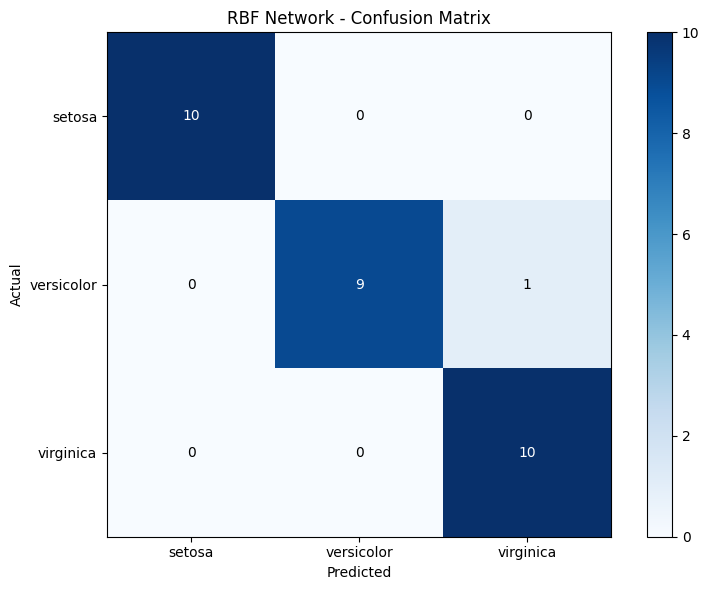

In [6]:
# Evaluate the RBF network

# Predictions
y_train_pred = rbf.predict(X_train)
y_test_pred = rbf.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)

print("RBF Network Results")
print("=" * 40)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_test_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Visualise confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=iris.target_names,
    yticklabels=iris.target_names,
    title='RBF Network - Confusion Matrix',
    ylabel='Actual',
    xlabel='Predicted')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")
        
plt.tight_layout()
plt.savefig('rbf_confusion_matrix.png', dpi=150)
plt.show()